# ANA 540 Final Examination - Classification using Logistic Regression

In [3]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import pandas as pd
import seaborn as sns
import requests
import os

from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize = 10)
plt.rc('ytick', labelsize = 10)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "Classification"

In [4]:
import urllib.request
from pathlib import Path

IMAGES_PATH = Path() / "images" / "Classification"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [5]:
descriptors_url = 'https://raw.githubusercontent.com/LukeWoodSMU/Mushroom-Classification/master/raw_data/descriptors.txt'
descriptors = requests.get(descriptors_url).text

def get_attribute_dictionary():
    # Loads from the descriptors file all attributes w/ mapping to their mappings
    attr_dict = dict([(x.split(":")[0],dict([[y.split("=")[1].strip(),y.split("=")[0].strip()] for y in x.split(":")[1].split(",")])) for x in descriptors.splitlines()])
    attr_dict.pop('stalk-root', None)
    return attr_dict
    

def get_data_frame(remove_dups=False):
    attribute_names = [x.split(":")[0] for x in descriptors.splitlines()]
    df = pd.read_csv('https://raw.githubusercontent.com/LukeWoodSMU/Mushroom-Classification/master/raw_data/agaricus-lepiota.data.txt',names=attribute_names)

    for col in df.columns:
        df[col] = df[col].astype('category')

    if(remove_dups):
        df = df.drop_duplicates()
    
    df.drop('stalk-root', inplace=True, axis=1)
    
    return df

In [6]:
df = get_data_frame()
total_rows = len(df)

df.drop_duplicates(inplace=True)
no_dups = len(df)

print ("Total duplicates: ", (total_rows - no_dups))

Total duplicates:  0


In [7]:
df

,poisonous,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,e,k,s,n,f,n,a,c,b,y,...,s,o,o,p,o,o,p,b,c,l
8120,e,x,s,n,f,n,a,c,b,y,...,s,o,o,p,n,o,p,b,v,l
8121,e,f,s,n,f,n,a,c,b,n,...,s,o,o,p,o,o,p,b,c,l
8122,p,k,y,n,f,y,f,c,n,b,...,k,w,w,p,w,o,e,w,v,l


In [8]:
df.rename(columns = {'poisonous':'class'}, inplace=True)

In [9]:
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [10]:
#What data is there? 
df.dtypes

class                       category
cap-shape                   category
cap-surface                 category
cap-color                   category
bruises                     category
odor                        category
gill-attachment             category
gill-spacing                category
gill-size                   category
gill-color                  category
stalk-shape                 category
stalk-surface-above-ring    category
stalk-surface-below-ring    category
stalk-color-above-ring      category
stalk-color-below-ring      category
veil-type                   category
veil-color                  category
ring-number                 category
ring-type                   category
spore-print-color           category
population                  category
habitat                     category
dtype: object

In [11]:
#Are there any missing values?
df.isnull().sum()

class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64

In [12]:
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [13]:
# Using LabelEncoder to convert catergory values to ordinal
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
for column in df.columns:
    df[column] = labelencoder.fit_transform(df[column])

df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,5,2,4,1,6,1,0,1,4,...,2,7,7,0,2,1,4,2,3,5
1,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
2,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
3,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
4,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1


In [14]:
df.describe()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,...,8124.000000,8124.000000,8124.000000,8124.0,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000
mean,0.482029,3.348104,1.827671,4.504677,0.415559,4.144756,0.974151,0.161497,0.309207,4.810684,...,1.603644,5.816347,5.794682,0.0,1.965534,1.069424,2.291974,3.596750,3.644018,1.508616
std,0.499708,1.604329,1.229873,2.545821,0.492848,2.103729,0.158695,0.368011,0.462195,3.540359,...,0.675974,1.901747,1.907291,0.0,0.242669,0.271064,1.801672,2.382663,1.252082,1.719975
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,3.000000,0.000000,2.000000,1.000000,0.000000,0.000000,2.000000,...,1.000000,6.000000,6.000000,0.0,2.000000,1.000000,0.000000,2.000000,3.000000,0.000000
50%,0.000000,3.000000,2.000000,4.000000,0.000000,5.000000,1.000000,0.000000,0.000000,5.000000,...,2.000000,7.000000,7.000000,0.0,2.000000,1.000000,2.000000,3.000000,4.000000,1.000000
75%,1.000000,5.000000,3.000000,8.000000,1.000000,5.000000,1.000000,0.000000,1.000000,7.000000,...,2.000000,7.000000,7.000000,0.0,2.000000,1.000000,4.000000,7.000000,4.000000,2.000000
max,1.000000,5.000000,3.000000,9.000000,1.000000,8.000000,1.000000,1.000000,1.000000,11.000000,...,3.000000,8.000000,8.000000,0.0,3.000000,2.000000,4.000000,8.000000,5.000000,6.000000


#### Now do your exploratory data analysis

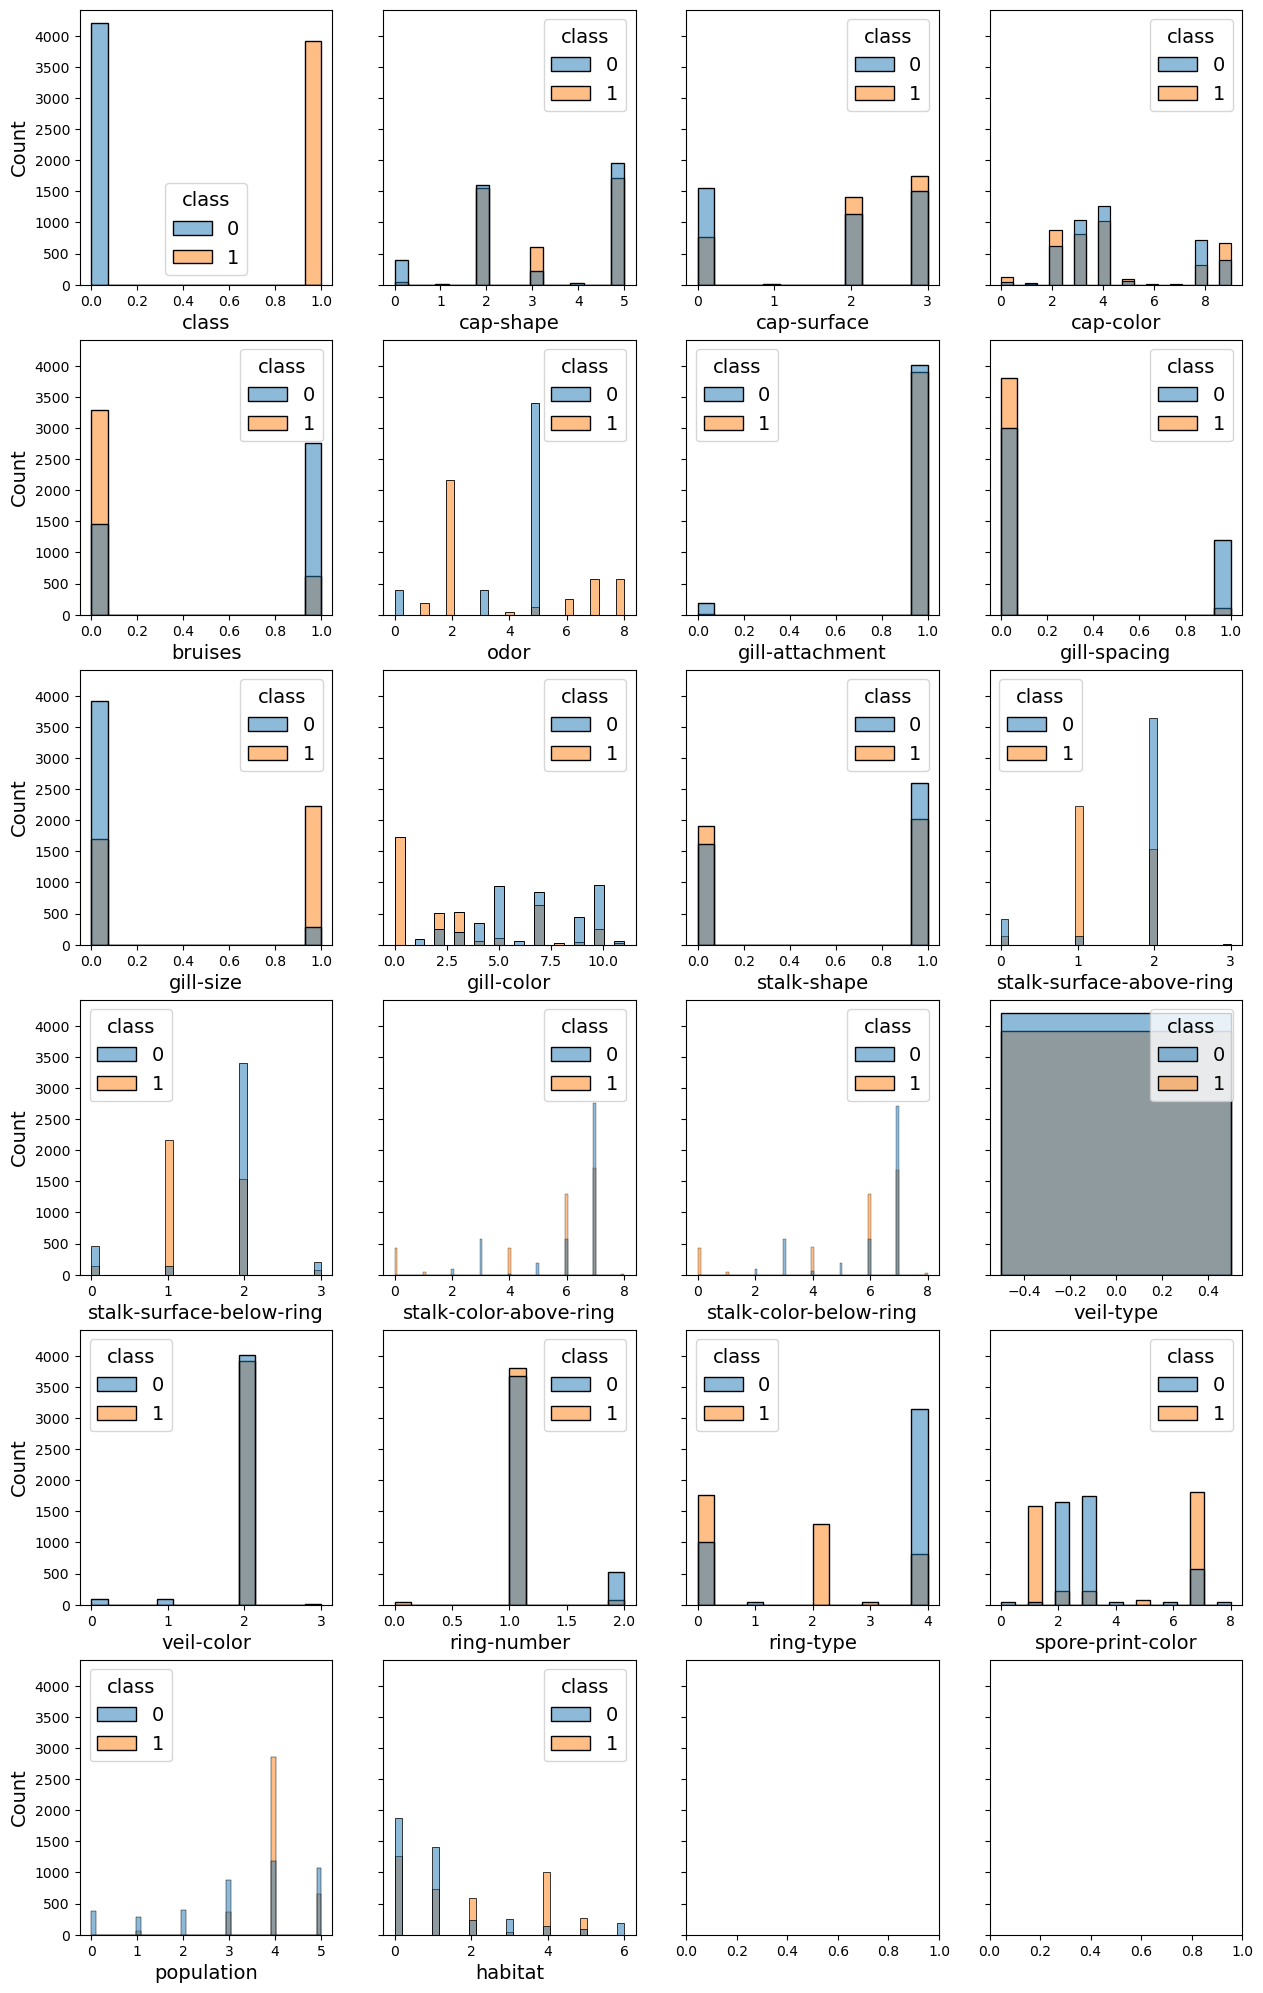

In [15]:
fig, axs = plt.subplots(6,4, figsize = (15, 25), sharey = True)
atr = list(df.columns)
for name, ax in zip(atr,axs.flatten()) :
    sns.histplot(ax = ax, data=df, x = name, hue = 'class')

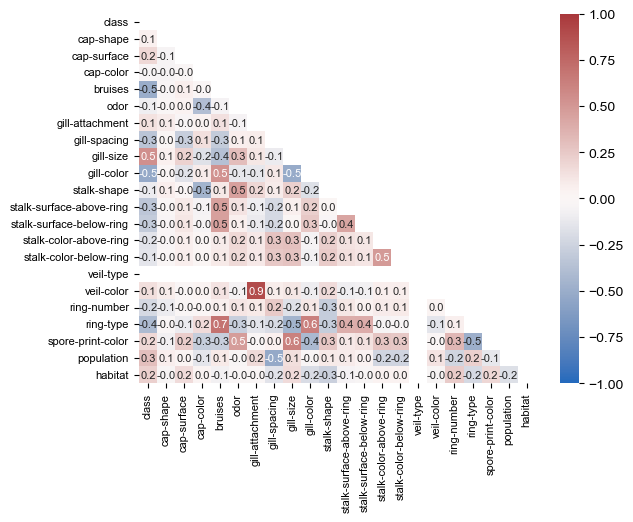

In [16]:
import seaborn as sns
corr=df.corr()
matrix = df.corr().round(2)
mask = np.triu(np.ones_like(matrix, dtype=bool))
sns.heatmap(corr,annot=True, annot_kws={'size': 8}, fmt=".1f", vmax=1, vmin=-1, center=0, cmap='vlag', mask=mask)
sns.set(rc = {'figure.figsize':(30,30)})
plt.tick_params(axis='both', which='major', labelsize=8)

In [17]:
from sklearn.model_selection import train_test_split
# "class" column as numpy array.
y = df["class"].values
# All data except "class" column.
x = df.drop(["class"], axis=1).values
# Split data for train and test.
x_train, x_test, y_train, y_test = train_test_split(x,y,random_state=42,test_size=0.2)

In [18]:
df['class'].value_counts(sort=False)

1    3916
0    4208
Name: class, dtype: int64

For our dataset, 1 is "poisonous" and 0 is "edible" or "non-poisonous"

In [19]:
#Let's just check and see if we have the definition of our 1's and 0's straight
#We can check against the data translated at https://fderyckel.github.io/machinelearningwithr/case-study-mushrooms-classification.html 
df['class'].head()

0    1
1    0
2    0
3    1
4    0
Name: class, dtype: int32

In [20]:
from sklearn.linear_model import LogisticRegression

## lr = LogisticRegression(solver="lbfgs")
lr = LogisticRegression(solver="liblinear", random_state=0)
lr.fit(x_train,y_train)

print("Test Accuracy: {}%".format(round(lr.score(x_test,y_test)*100,2)))

Test Accuracy: 94.4%


In [21]:
def get_hist_data():
    attr_map = get_attribute_dictionary()
    df = get_data_frame()

    hist_data = dict([(atr,None) for atr in attr_map])
    poison_hist_data = dict([(atr,None) for atr in attr_map])

    for x in attr_map:
        counts = dict([(attr_map[x][y],0) for y in attr_map[x]])
        poison_counts = dict([(attr_map[x][y],0) for y in attr_map[x]])

        for val, poison in zip(df[x],df["poisonous"]):
            counts[attr_map[x][val]]+=1
            if(poison == "p"):
                poison_counts[attr_map[x][val]]+=1
        hist_data[x] = counts
        poison_hist_data[x] = poison_counts

    return hist_data, poison_hist_data

#tf_tpf - Term Frquency to Poison Frequency
def get_tf_tpf():
    data,poison_data = get_hist_data()
    tf_tpf = {}

    for val in data:
        tf_tpf[val] = dict([(x,poison_data[val][x]/data[val][x]) for x in data[val] if data[val][x] != 0])
    return tf_tpf

counts, poison_counts = get_hist_data()

tf_tpf = {}
for val in counts:
    tf_tpf[val] = dict([(x,poison_counts[val][x]/counts[val][x]) for x in counts[val] if counts[val][x] != 0])

print(tf_tpf["odor"])

{'almond': 0.0, 'anise': 0.0, 'creosote': 1.0, 'fishy': 1.0, 'foul': 1.0, 'musty': 1.0, 'none': 0.034013605442176874, 'pungent': 1.0, 'spicy': 1.0}


In [59]:
def attr_freqs(attr1, attr2):
    df = get_data_frame()

    labels1 = get_attribute_dictionary()[attr1]
    labels2 = get_attribute_dictionary()[attr2]

    data = []

    for a in df[attr1].cat.categories:
        column = df[attr2][df[attr1] == a].value_counts()
        data.append(column)

    observed = pd.concat(data, axis=1)
    observed.columns = [labels1[a] for a in df[attr1].cat.categories]

    return observed


attr_freqs('odor', 'poisonous')

,almond,creosote,foul,anise,musty,none,pungent,spicy,fishy
e,400,0,0,400,0,3408,0,0,0
p,0,192,2160,0,36,120,256,576,576


In [60]:
#Set up to plot histograms by attribute and whether poisonous or edible

def plot_comparative_data(attr, plot=True, save=False):
    data = attr_freqs(attr, 'poisonous')

    labels = get_attribute_dictionary()[attr]

    index = np.arange(data.shape[1])
    bar_width = 0.35
    opacity=0.4

    fig, ax = plt.subplots()

    plt.bar(index, data.loc['e',:].values, bar_width, align='center',
            color='b', label='edible', alpha=opacity)
    plt.bar(index + bar_width, data.loc['p',:].values, bar_width,
            align='center', color='r', label='poisonous', alpha=opacity)

    plt.xlabel('Attributes', fontsize=30)
    plt.ylabel('Frequency', fontsize=30)
    plt.title('Frequency by attribute and edibility ({})'.format(attr), fontsize=40)
    plt.xticks(index + bar_width / 2, data.columns, fontsize=30)

    plt.legend(fontsize = 30)

    plt.tight_layout()
    plt.show()
    plt.close()

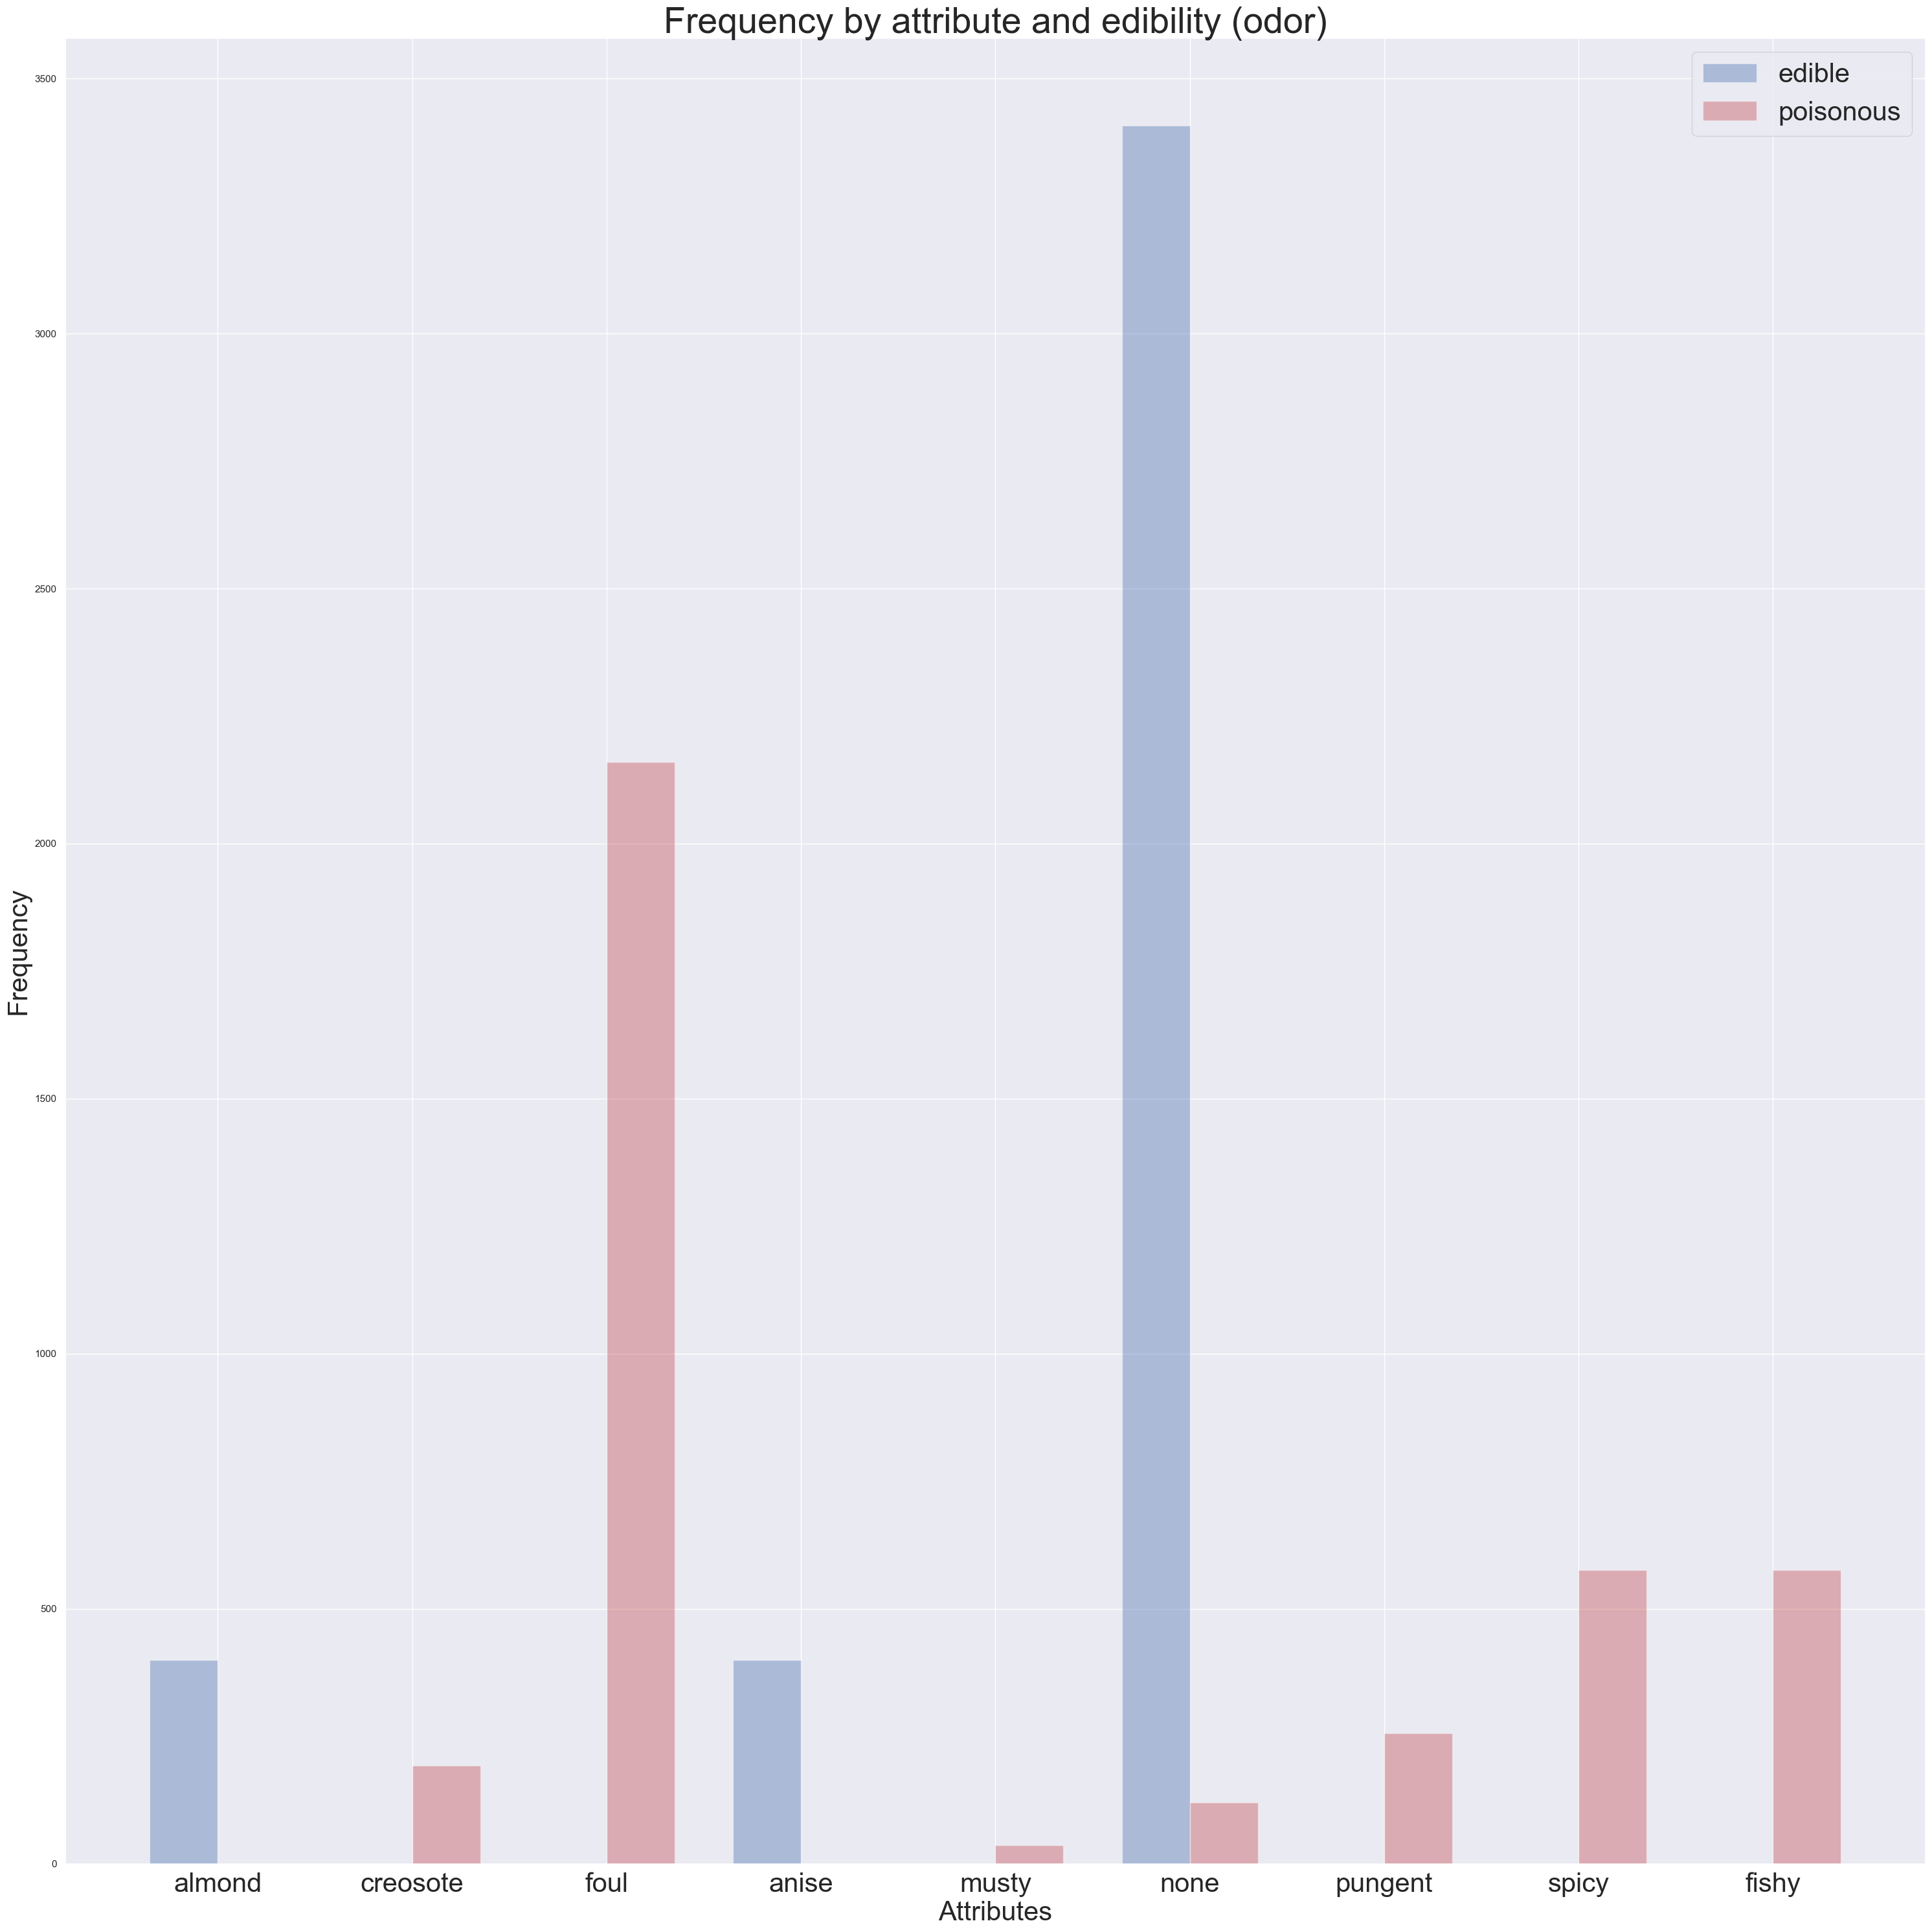

In [61]:
plot_comparative_data('odor')

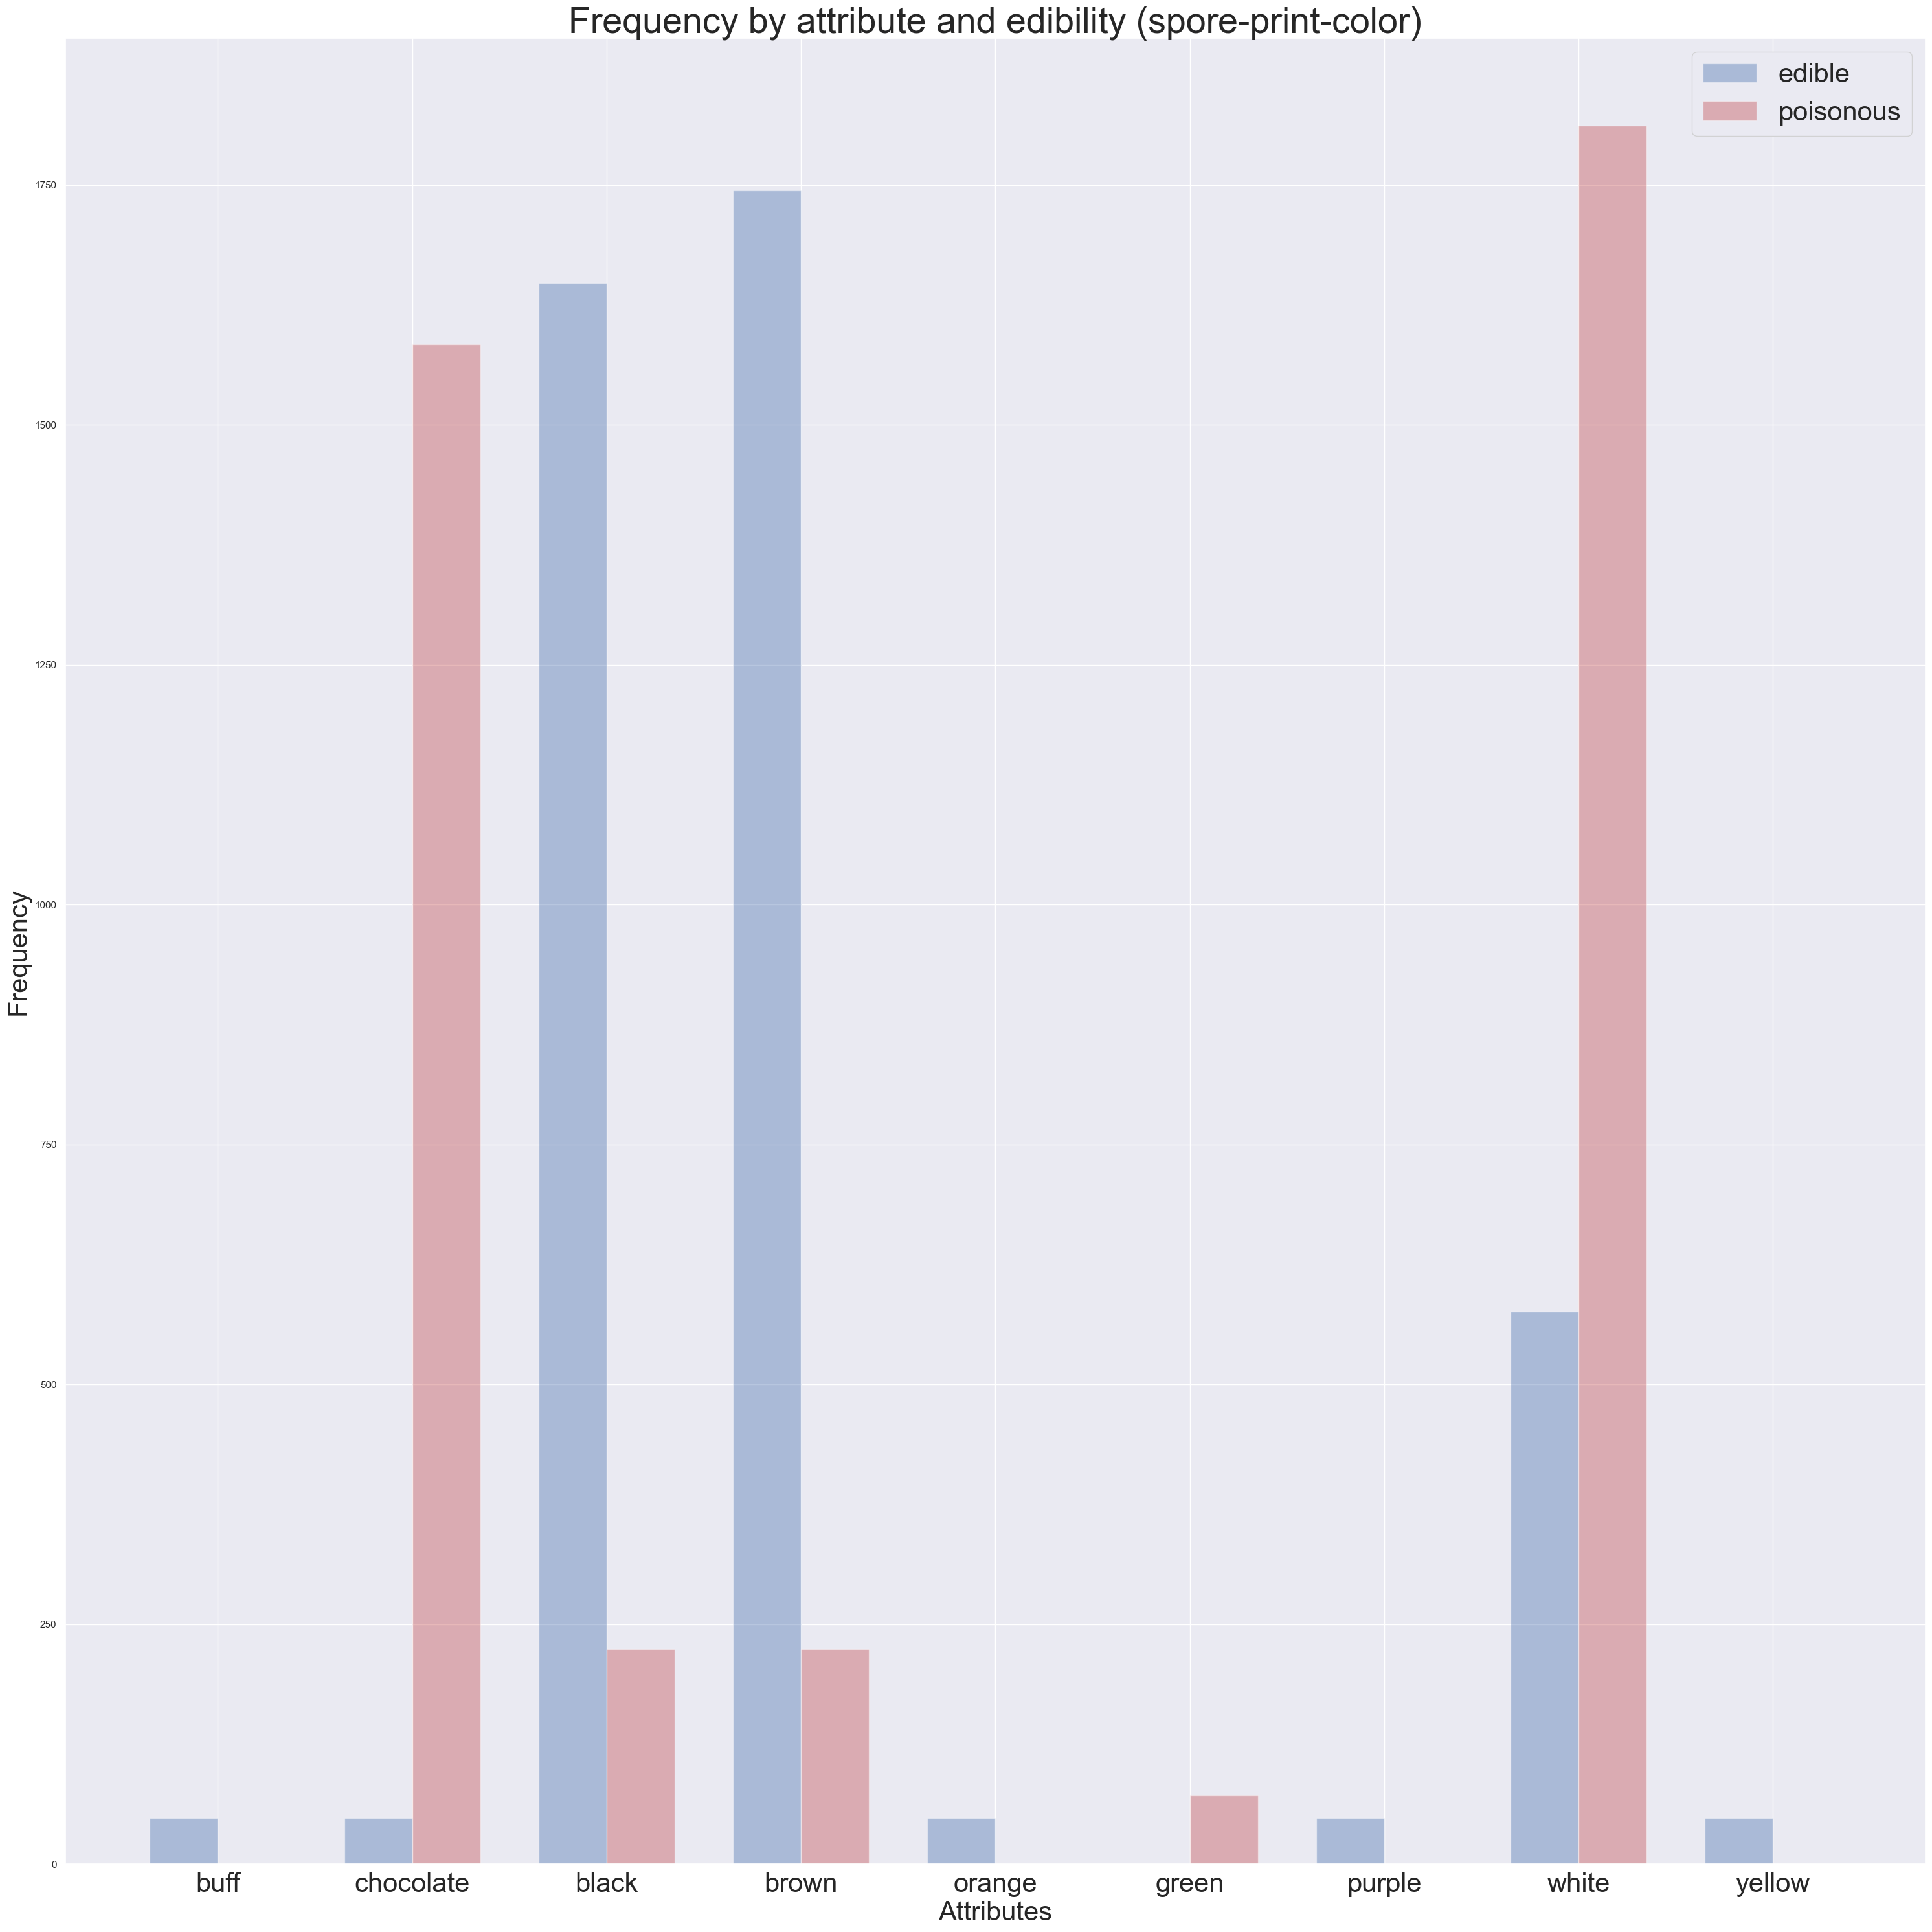

In [62]:
plot_comparative_data('spore-print-color')

In [63]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred = lr.predict(x_test)

#I have checked the order of tn, fp, fn, and tp w.r.t. the confusion matrix() command and the 
#following is the correct order
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print("\n")
print("Confusion Maxtrix")
print(confusion_matrix(y_test, y_pred))
print()
print()

print(f'\nTrue Positives: {tp}')
print(f'\nFalse Positives: {fp}')
print(f'\nTrue Negatives: {tn}')
print(f'\nFalse Negatives: {fn}')

print()
print()
print(f'True Positive Rate: { (tp / (tp + fn))}')
print(f'Specificity: { (tn / (tn + fp))}')
print(f'False Positive Rate: { (fp / (fp + tn))}')

tpr = (tp / (tp + fn))
fpr = (tn / (tn + fp))



Confusion Maxtrix
[[799  44]
 [ 47 735]]



True Positives: 735

False Positives: 44

True Negatives: 799

False Negatives: 47


True Positive Rate: 0.9398976982097187
Specificity: 0.9478054567022538
False Positive Rate: 0.05219454329774614


In [64]:
# classification report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       843
           1       0.94      0.94      0.94       782

    accuracy                           0.94      1625
   macro avg       0.94      0.94      0.94      1625
weighted avg       0.94      0.94      0.94      1625



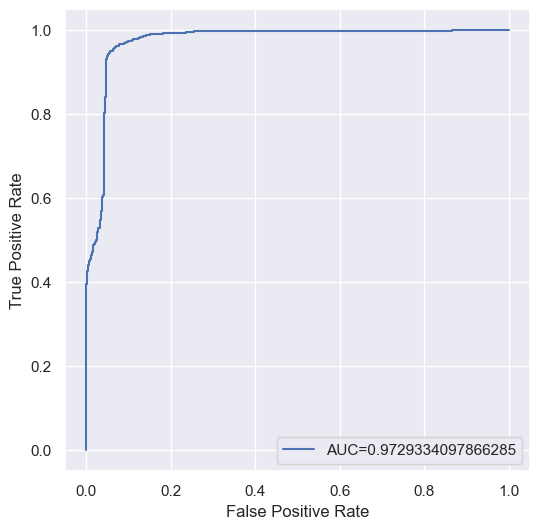

In [65]:
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

y_pred_proba = lr.predict_proba(x_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

plt_1 = plt.figure(figsize=(6,6))

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

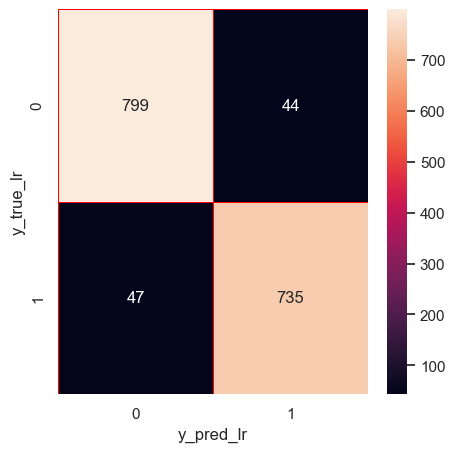

In [66]:
from sklearn.metrics import confusion_matrix
# Logistic Regression
y_pred_lr = lr.predict(x_test)
y_true_lr = y_test
cm = confusion_matrix(y_true_lr, y_pred_lr)
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm,annot = True,linewidths=0.5,linecolor="red",fmt = ".0f",ax=ax)
plt.xlabel("y_pred_lr")
plt.ylabel("y_true_lr")
plt.show()

### Determining an attribute's association with edibility

This section is taken directly from https://notebook.community/LukeWoodSMU/Mushroom-Classification/DraftReport 

To determine association between attributes and edibility we used Pearson's chi-squared test on the frequency of attribute values and then ordered the attributes in descending order of the chi-squared statistic. The chi-squared test works by comparing the observed data to expected data (the null hypothesis which is an even distribution across each row and column) with the following equation,

$$ \chi^2 = \sum^n_{i=1} \frac{ (O_i - E_i)^2 }{ E_i } $$
where $O$ is the observed data point and $E$ is the expected data point.

With the following function we can get a contingency table of the expected and observed values of any two attributes:

In [67]:
def expected_data(observed):
    expected = np.zeros(observed.shape)

    total = observed.sum().sum()
    for j in [0, 1]:
        for i, col_total in enumerate(observed.sum()):
            row_total = observed.sum(axis=1)[j]
            expected[j][i] = row_total*col_total/total

    return pd.DataFrame(expected, index=observed.index,
                        columns=observed.columns)

In [68]:
o = attr_freqs('odor', 'poisonous')
o

,almond,creosote,foul,anise,musty,none,pungent,spicy,fishy
e,400,0,0,400,0,3408,0,0,0
p,0,192,2160,0,36,120,256,576,576


In [69]:
expected_data(o)

,almond,creosote,foul,anise,musty,none,pungent,spicy,fishy
e,207.188577,99.450517,1118.818316,207.188577,18.646972,1827.40325,132.600689,298.351551,298.351551
p,192.811423,92.549483,1041.181684,192.811423,17.353028,1700.59675,123.399311,277.648449,277.648449


Using these two tables for each attribute we can collect the chi-squared test statistic for each, and then sort them in descending order to rank the attributes by association with being poisonous or edible.

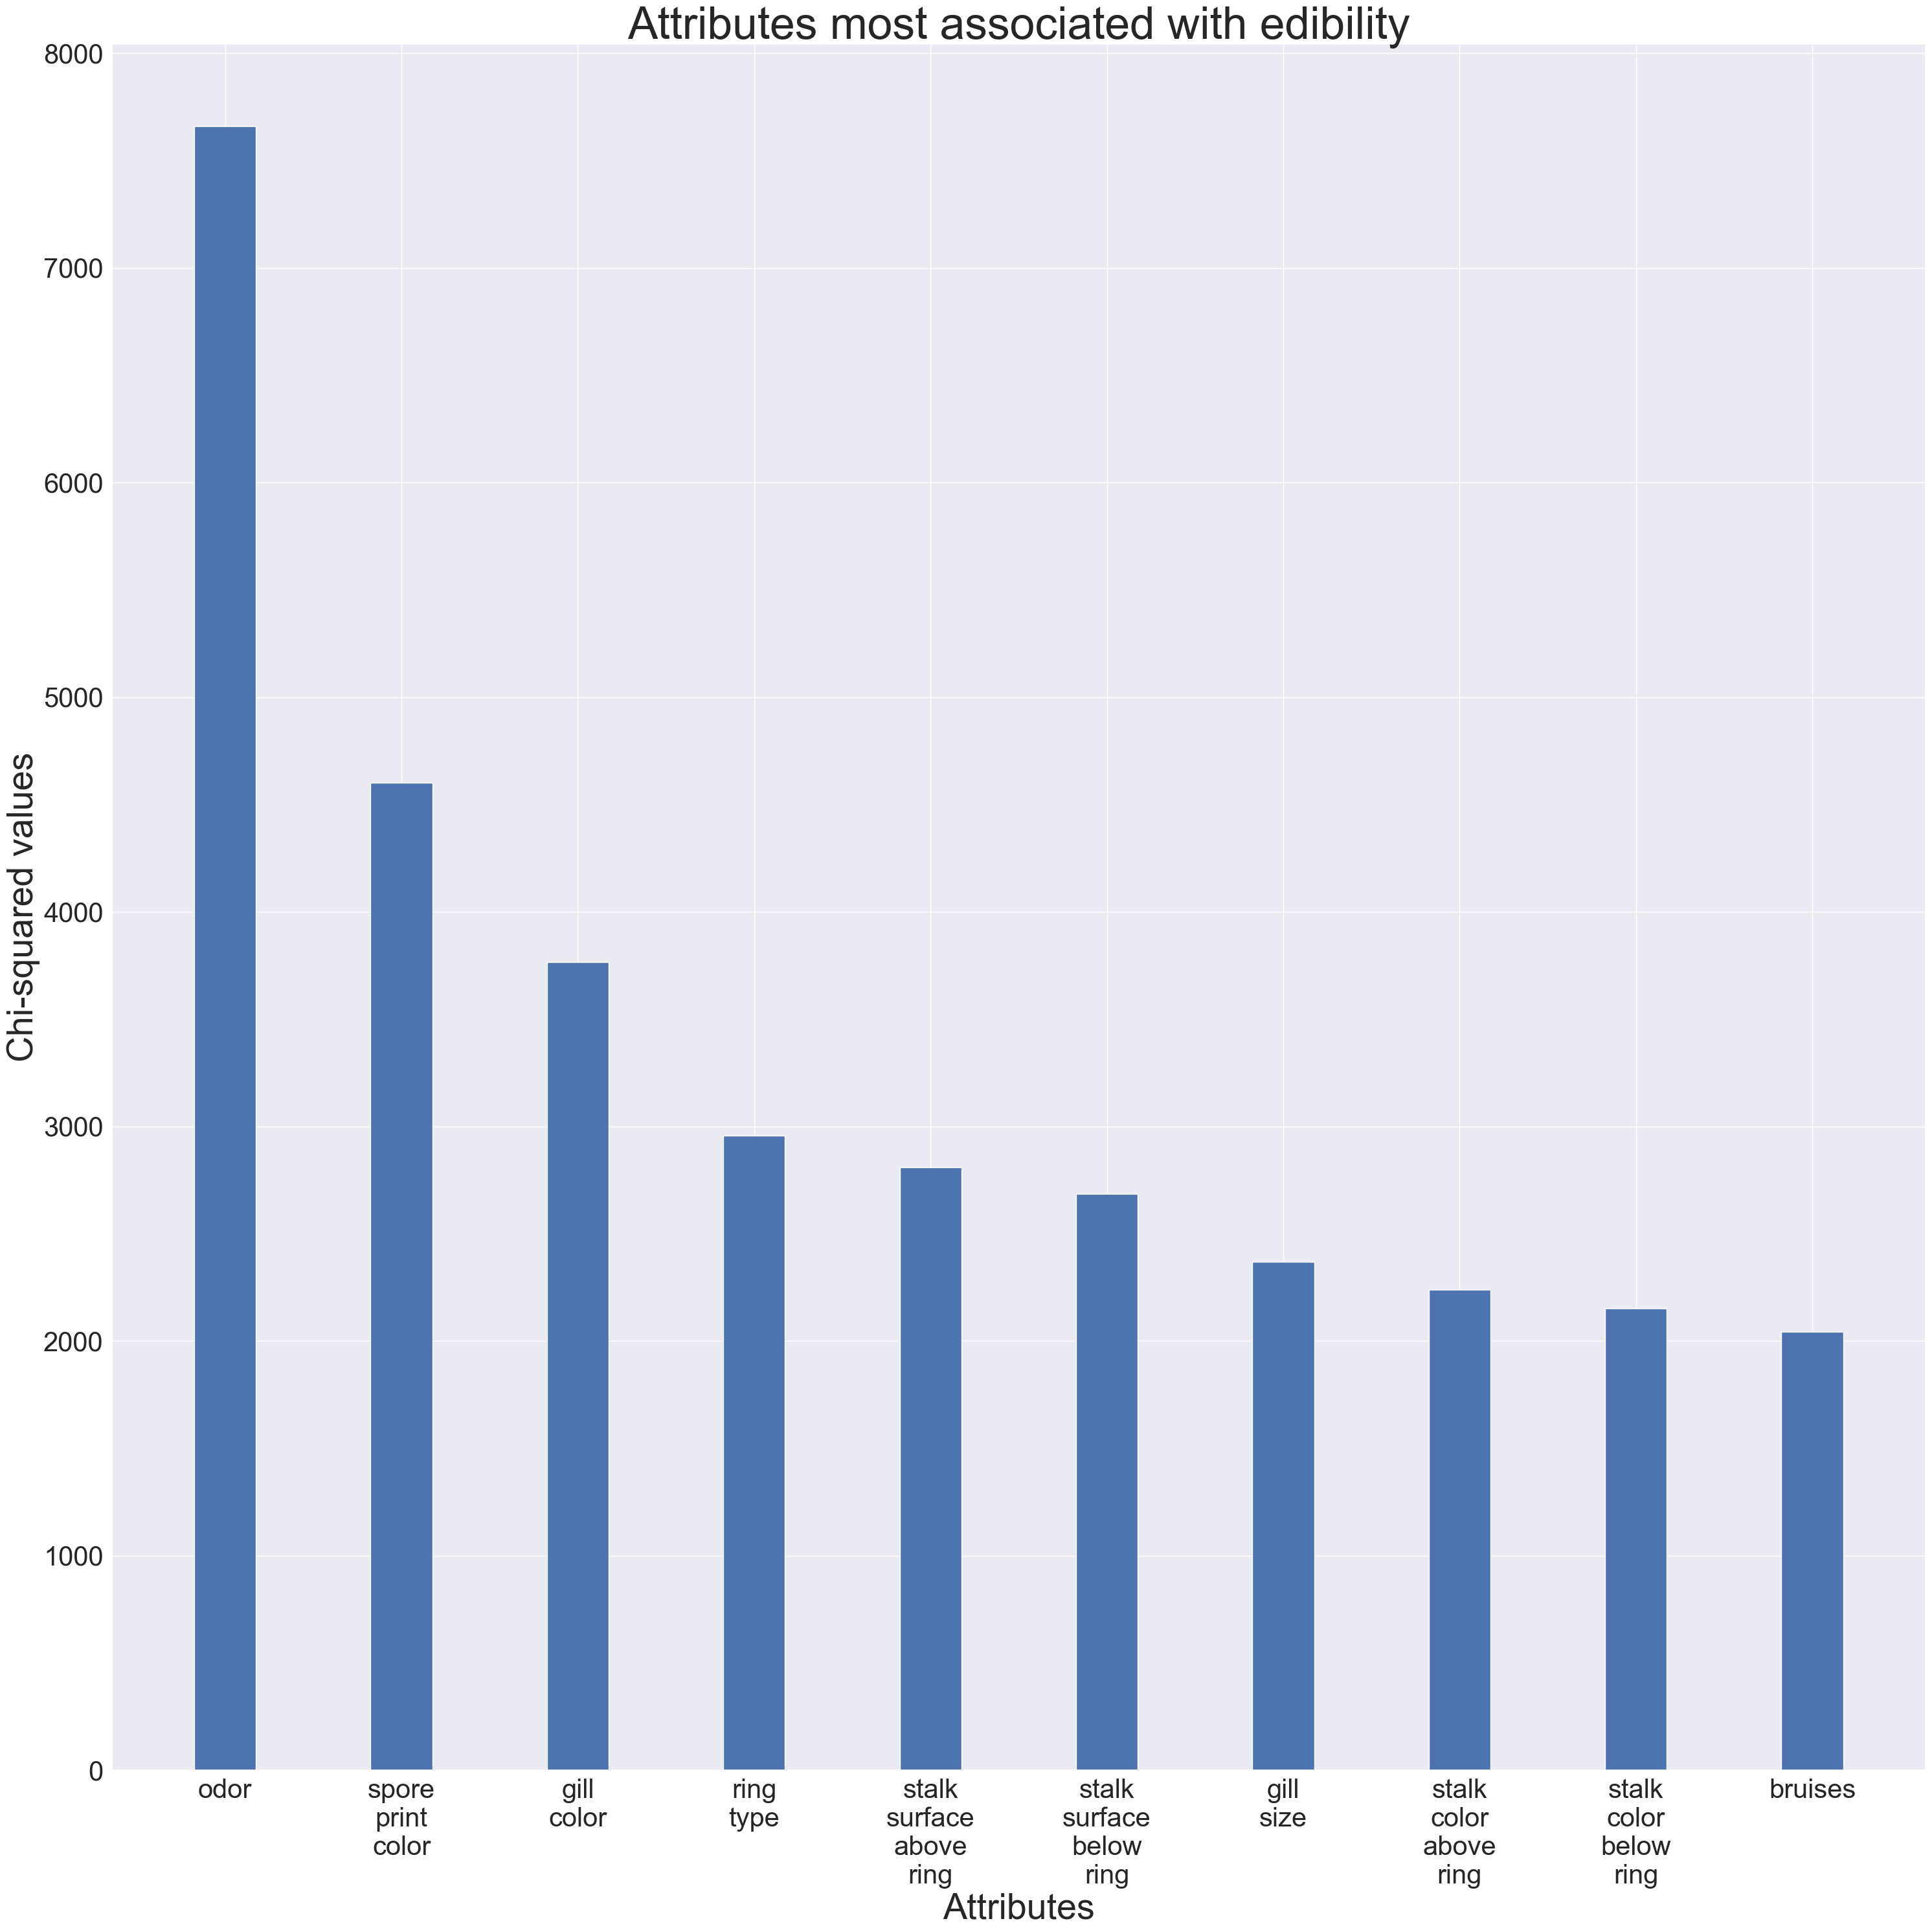

In [70]:
cat_names = get_attribute_dictionary().keys()

chisqrs = []
for cat in cat_names:
    if cat != 'poisonous':
        observed = attr_freqs(cat, 'poisonous')
        expected = expected_data(observed)
        chisqr = (((observed-expected)**2)/expected).sum().sum()
        chisqrs.append((chisqr, cat))

chisqrs = sorted(chisqrs)[::-1]
chisqrs = chisqrs[:10]
values = [d[0] for d in chisqrs]
labels = [d[1].replace("-", "\n") for d in chisqrs]

index = np.arange(len(chisqrs))
bar_width = .35
opacity=0.4

plt.title("Attributes most associated with edibility", fontsize = 50)
plt.bar(index, values, bar_width, align='center')
plt.xticks(index, labels, fontsize=30)
plt.yticks(fontsize = 30)
plt.ylabel("Chi-squared values", fontsize=40)
plt.xlabel("Attributes", fontsize=40)
plt.autoscale()
plt.tight_layout()
plt.show()